In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Jul 16 10:18:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 42%   59C    P2   112W / 250W |   7133MiB / 12066MiB |     89%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mds_07July2020 import SimpleCNN5Layer_Ca as Model
from model.models_mds_07July2020 import SimpleCNN5Layer_Ca_B as Model_B
from model.models_mds_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mds_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mds_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mds_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mds_07July2020 import All_CNN6Layer_E as ModelE

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(1)

1 available GPUs (initially using device 0):
  0 Tesla P100-PCIE-16GB


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 118)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 12.76 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.62 s
Constructing 160000 event dataset took 3.414 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.004 s
Constructing 9984 event dataset took 0.0771 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelA()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path, freeze_weights=True)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/d4c36a4ce6a24fa084bf844256bee04f/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=True)

we also froze 5 weights
Of the 6.0 parameter layers to update in the current model, 5.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_A(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


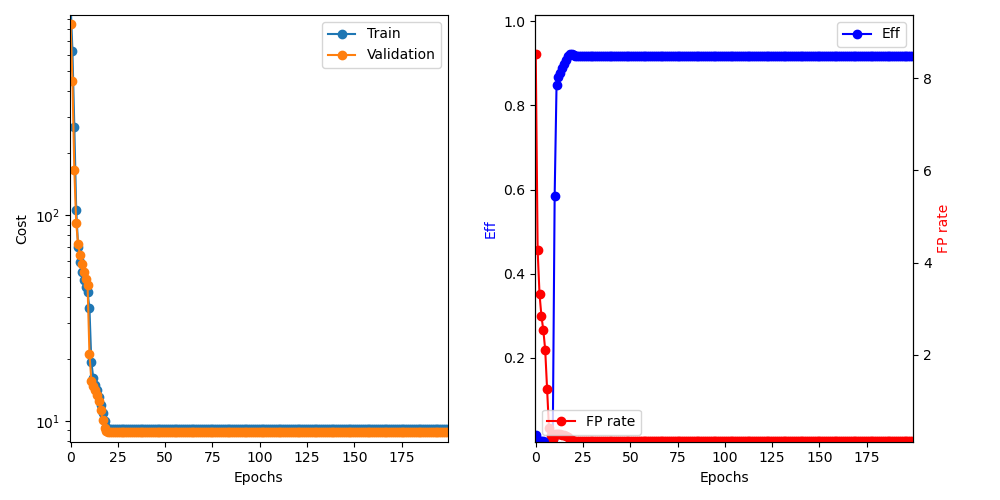

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  All_CNN6Layer_A(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)
epoch_start 118
batch_size 128
epochs 200
lr 0.001
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 118: train=1088.59, val=852.637, took 17.296 s
  Validation Found 968 of 54504, added 85127 (eff 1.78%) (8.53 FP/event)


Epoch 119: train=629.181, val=448.489, took 17.187 s
  Validation Found 201 of 54504, added 42574 (eff 0.37%) (4.26 FP/event)


Epoch 120: train=269.49, val=166.344, took 17.045 s
  Validation Found 113 of 54504, added 33065 (eff 0.21%) (3.31 FP/event)


Epoch 121: train=106.499, val=91.3054, took 16.868 s
  Validation Found 94 of 54504, added 28354 (eff 0.17%) (2.84 FP/event)


Epoch 122: train=70.2468, val=72.5532, took 16.738 s
  Validation Found 81 of 54504, added 25289 (eff 0.15%) (2.53 FP/event)


Epoch 123: train=59.1984, val=63.827, took 16.601 s
  Validation Found 68 of 54504, added 21001 (eff 0.12%) (2.1 FP/event)


Epoch 124: train=53.1285, val=57.728, took 16.827 s
  Validation Found 58 of 54504, added 12446 (eff 0.11%) (1.25 FP/event)


Epoch 125: train=48.5642, val=52.8119, took 17.015 s
  Validation Found 57 of 54504, added 4018 (eff 0.10%) (0.402 FP/event)


Epoch 126: train=45.0063, val=48.9843, took 17.039 s
  Validation Found 81 of 54504, added 2451 (eff 0.15%) (0.245 FP/event)


Epoch 127: train=42.1999, val=45.8406, took 16.393 s
  Validation Found 360 of 54504, added 1563 (eff 0.66%) (0.157 FP/event)


Epoch 128: train=35.311, val=21.1892, took 17.259 s
  Validation Found 31912 of 54504, added 2699 (eff 58.55%) (0.27 FP/event)


Epoch 129: train=19.3528, val=15.7158, took 17.238 s
  Validation Found 46293 of 54504, added 2798 (eff 84.94%) (0.28 FP/event)


Epoch 130: train=16.2677, val=14.7917, took 17.2 s
  Validation Found 47230 of 54504, added 2761 (eff 86.65%) (0.277 FP/event)


Epoch 131: train=15.0411, val=14.1527, took 17.822 s
  Validation Found 47852 of 54504, added 2715 (eff 87.80%) (0.272 FP/event)


Epoch 132: train=14.1117, val=13.4295, took 17.67 s
  Validation Found 48442 of 54504, added 2620 (eff 88.88%) (0.262 FP/event)


Epoch 133: train=13.1205, val=12.4611, took 17.987 s
  Validation Found 48990 of 54504, added 2452 (eff 89.88%) (0.246 FP/event)


Epoch 134: train=11.998, val=11.2619, took 18.327 s
  Validation Found 49514 of 54504, added 2241 (eff 90.84%) (0.224 FP/event)


Epoch 135: train=10.8845, val=10.095, took 18.934 s
  Validation Found 49939 of 54504, added 1990 (eff 91.62%) (0.199 FP/event)


Epoch 136: train=9.95963, val=9.26902, took 18.3 s
  Validation Found 50274 of 54504, added 1706 (eff 92.24%) (0.171 FP/event)


Epoch 137: train=9.39742, val=8.90601, took 18.791 s
  Validation Found 50259 of 54504, added 1416 (eff 92.21%) (0.142 FP/event)


Epoch 138: train=9.18971, val=8.83537, took 18.905 s
  Validation Found 50083 of 54504, added 1260 (eff 91.89%) (0.126 FP/event)


Epoch 139: train=9.15173, val=8.82664, took 18.737 s
  Validation Found 50025 of 54504, added 1212 (eff 91.78%) (0.121 FP/event)


Epoch 140: train=9.14768, val=8.83818, took 18.528 s
  Validation Found 49991 of 54504, added 1191 (eff 91.72%) (0.119 FP/event)


Epoch 141: train=9.14873, val=8.83601, took 19.069 s
  Validation Found 49995 of 54504, added 1195 (eff 91.73%) (0.12 FP/event)


Epoch 142: train=9.15016, val=8.83834, took 18.657 s
  Validation Found 49980 of 54504, added 1187 (eff 91.70%) (0.119 FP/event)


Epoch 143: train=9.14643, val=8.8523, took 19.128 s
  Validation Found 49955 of 54504, added 1178 (eff 91.65%) (0.118 FP/event)


Epoch 144: train=9.14538, val=8.82939, took 18.717 s
  Validation Found 49999 of 54504, added 1193 (eff 91.73%) (0.119 FP/event)


Epoch 145: train=9.15023, val=8.82479, took 18.63 s
  Validation Found 49979 of 54504, added 1187 (eff 91.70%) (0.119 FP/event)


Epoch 146: train=9.14825, val=8.83017, took 18.894 s
  Validation Found 49984 of 54504, added 1185 (eff 91.71%) (0.119 FP/event)


Epoch 147: train=9.14855, val=8.83754, took 18.513 s
  Validation Found 49971 of 54504, added 1180 (eff 91.68%) (0.118 FP/event)


Epoch 148: train=9.14561, val=8.83223, took 18.167 s
  Validation Found 49998 of 54504, added 1195 (eff 91.73%) (0.12 FP/event)


Epoch 149: train=9.14893, val=8.82889, took 18.113 s
  Validation Found 50000 of 54504, added 1198 (eff 91.74%) (0.12 FP/event)


Epoch 150: train=9.14846, val=8.83242, took 18.791 s
  Validation Found 50000 of 54504, added 1196 (eff 91.74%) (0.12 FP/event)


Epoch 151: train=9.14717, val=8.82296, took 18.977 s
  Validation Found 50014 of 54504, added 1207 (eff 91.76%) (0.121 FP/event)


Epoch 152: train=9.1479, val=8.83394, took 18.617 s
  Validation Found 49982 of 54504, added 1182 (eff 91.70%) (0.118 FP/event)


Epoch 153: train=9.15072, val=8.84578, took 18.34 s
  Validation Found 49960 of 54504, added 1181 (eff 91.66%) (0.118 FP/event)


Epoch 154: train=9.1514, val=8.82567, took 18.517 s
  Validation Found 50011 of 54504, added 1204 (eff 91.76%) (0.121 FP/event)


Epoch 155: train=9.15188, val=8.83147, took 18.114 s
  Validation Found 50021 of 54504, added 1201 (eff 91.77%) (0.12 FP/event)


Epoch 156: train=9.15126, val=8.84172, took 18.343 s
  Validation Found 49989 of 54504, added 1194 (eff 91.72%) (0.12 FP/event)


Epoch 157: train=9.1519, val=8.82745, took 18.428 s
  Validation Found 49986 of 54504, added 1188 (eff 91.71%) (0.119 FP/event)


Epoch 158: train=9.14936, val=8.84329, took 17.798 s
  Validation Found 49999 of 54504, added 1192 (eff 91.73%) (0.119 FP/event)


Epoch 159: train=9.14957, val=8.83213, took 18.344 s
  Validation Found 49993 of 54504, added 1191 (eff 91.72%) (0.119 FP/event)


Epoch 160: train=9.14757, val=8.82273, took 18.442 s
  Validation Found 50000 of 54504, added 1197 (eff 91.74%) (0.12 FP/event)


Epoch 161: train=9.14944, val=8.83784, took 18.433 s
  Validation Found 49999 of 54504, added 1195 (eff 91.73%) (0.12 FP/event)


Epoch 162: train=9.14621, val=8.83339, took 18.147 s
  Validation Found 49976 of 54504, added 1185 (eff 91.69%) (0.119 FP/event)


Epoch 163: train=9.14886, val=8.84527, took 18.602 s
  Validation Found 49975 of 54504, added 1184 (eff 91.69%) (0.119 FP/event)


Epoch 164: train=9.15248, val=8.83159, took 18.192 s
  Validation Found 50001 of 54504, added 1196 (eff 91.74%) (0.12 FP/event)


Epoch 165: train=9.14935, val=8.83092, took 18.54 s
  Validation Found 49978 of 54504, added 1186 (eff 91.70%) (0.119 FP/event)


Epoch 166: train=9.14962, val=8.83123, took 18.988 s
  Validation Found 49987 of 54504, added 1191 (eff 91.71%) (0.119 FP/event)


Epoch 167: train=9.14892, val=8.83923, took 18.304 s
  Validation Found 49986 of 54504, added 1195 (eff 91.71%) (0.12 FP/event)


Epoch 168: train=9.15072, val=8.82322, took 18.598 s
  Validation Found 50020 of 54504, added 1208 (eff 91.77%) (0.121 FP/event)


Epoch 169: train=9.14947, val=8.83017, took 18.428 s
  Validation Found 49992 of 54504, added 1195 (eff 91.72%) (0.12 FP/event)


Epoch 170: train=9.14599, val=8.83499, took 18.143 s
  Validation Found 50002 of 54504, added 1197 (eff 91.74%) (0.12 FP/event)


Epoch 171: train=9.15151, val=8.83695, took 18.032 s
  Validation Found 49999 of 54504, added 1201 (eff 91.73%) (0.12 FP/event)


Epoch 172: train=9.14501, val=8.83737, took 18.113 s
  Validation Found 49979 of 54504, added 1182 (eff 91.70%) (0.118 FP/event)


Epoch 173: train=9.14457, val=8.82479, took 18.675 s
  Validation Found 50011 of 54504, added 1208 (eff 91.76%) (0.121 FP/event)


Epoch 174: train=9.14086, val=8.82543, took 18.431 s
  Validation Found 49984 of 54504, added 1185 (eff 91.71%) (0.119 FP/event)


Epoch 175: train=9.14486, val=8.83121, took 18.611 s
  Validation Found 50001 of 54504, added 1198 (eff 91.74%) (0.12 FP/event)


Epoch 176: train=9.15238, val=8.82915, took 18.785 s
  Validation Found 49989 of 54504, added 1193 (eff 91.72%) (0.119 FP/event)


Epoch 177: train=9.1463, val=8.84572, took 18.57 s
  Validation Found 49976 of 54504, added 1185 (eff 91.69%) (0.119 FP/event)


Epoch 178: train=9.15052, val=8.83224, took 18.394 s
  Validation Found 49980 of 54504, added 1189 (eff 91.70%) (0.119 FP/event)


Epoch 179: train=9.14802, val=8.82446, took 18.718 s
  Validation Found 50014 of 54504, added 1198 (eff 91.76%) (0.12 FP/event)


Epoch 180: train=9.14947, val=8.83675, took 18.323 s
  Validation Found 50000 of 54504, added 1197 (eff 91.74%) (0.12 FP/event)


Epoch 181: train=9.14891, val=8.83084, took 18.776 s
  Validation Found 49995 of 54504, added 1193 (eff 91.73%) (0.119 FP/event)


Epoch 182: train=9.1488, val=8.83388, took 18.048 s
  Validation Found 49999 of 54504, added 1198 (eff 91.73%) (0.12 FP/event)


Epoch 183: train=9.14706, val=8.84123, took 18.579 s
  Validation Found 49979 of 54504, added 1187 (eff 91.70%) (0.119 FP/event)


Epoch 184: train=9.14467, val=8.83028, took 18.654 s
  Validation Found 50034 of 54504, added 1214 (eff 91.80%) (0.122 FP/event)


Epoch 185: train=9.14829, val=8.83411, took 18.109 s
  Validation Found 49998 of 54504, added 1197 (eff 91.73%) (0.12 FP/event)


Epoch 186: train=9.15014, val=8.82493, took 17.861 s
  Validation Found 50004 of 54504, added 1199 (eff 91.74%) (0.12 FP/event)


Epoch 187: train=9.14879, val=8.83724, took 18.324 s
  Validation Found 49992 of 54504, added 1191 (eff 91.72%) (0.119 FP/event)


Epoch 188: train=9.14779, val=8.82304, took 18.959 s
  Validation Found 50008 of 54504, added 1198 (eff 91.75%) (0.12 FP/event)


Epoch 189: train=9.14952, val=8.83028, took 17.954 s
  Validation Found 49986 of 54504, added 1189 (eff 91.71%) (0.119 FP/event)


Epoch 190: train=9.14749, val=8.82713, took 18.104 s
  Validation Found 49996 of 54504, added 1198 (eff 91.73%) (0.12 FP/event)


Epoch 191: train=9.14637, val=8.846, took 18.881 s
  Validation Found 49980 of 54504, added 1188 (eff 91.70%) (0.119 FP/event)


Epoch 192: train=9.14928, val=8.82422, took 18.517 s
  Validation Found 50008 of 54504, added 1201 (eff 91.75%) (0.12 FP/event)


Epoch 193: train=9.1483, val=8.82231, took 18.191 s
  Validation Found 50002 of 54504, added 1202 (eff 91.74%) (0.12 FP/event)


Epoch 194: train=9.14975, val=8.83008, took 17.841 s
  Validation Found 50012 of 54504, added 1200 (eff 91.76%) (0.12 FP/event)


Epoch 195: train=9.14739, val=8.82751, took 18.571 s
  Validation Found 50018 of 54504, added 1206 (eff 91.77%) (0.121 FP/event)


Epoch 196: train=9.14955, val=8.83399, took 18.302 s
  Validation Found 49988 of 54504, added 1189 (eff 91.71%) (0.119 FP/event)


Epoch 197: train=9.15275, val=8.8376, took 18.412 s
  Validation Found 49981 of 54504, added 1185 (eff 91.70%) (0.119 FP/event)


Epoch 198: train=9.14569, val=8.83835, took 18.762 s
  Validation Found 49969 of 54504, added 1182 (eff 91.68%) (0.118 FP/event)


Epoch 199: train=9.15233, val=8.84277, took 18.477 s
  Validation Found 49974 of 54504, added 1186 (eff 91.69%) (0.119 FP/event)


Epoch 200: train=9.146, val=8.83107, took 18.262 s
  Validation Found 49998 of 54504, added 1195 (eff 91.73%) (0.12 FP/event)


Epoch 201: train=9.14311, val=8.83, took 18.529 s
  Validation Found 49977 of 54504, added 1186 (eff 91.69%) (0.119 FP/event)


Epoch 202: train=9.14964, val=8.83216, took 18.729 s
  Validation Found 49987 of 54504, added 1188 (eff 91.71%) (0.119 FP/event)


Epoch 203: train=9.14885, val=8.82933, took 18.728 s
  Validation Found 49997 of 54504, added 1197 (eff 91.73%) (0.12 FP/event)


Epoch 204: train=9.14925, val=8.83373, took 18.715 s
  Validation Found 49988 of 54504, added 1187 (eff 91.71%) (0.119 FP/event)


Epoch 205: train=9.1506, val=8.84273, took 19.031 s
  Validation Found 50002 of 54504, added 1193 (eff 91.74%) (0.119 FP/event)


Epoch 206: train=9.14987, val=8.83809, took 18.85 s
  Validation Found 50000 of 54504, added 1194 (eff 91.74%) (0.12 FP/event)


Epoch 207: train=9.1488, val=8.83612, took 18.82 s
  Validation Found 50005 of 54504, added 1205 (eff 91.75%) (0.121 FP/event)


Epoch 208: train=9.14766, val=8.84072, took 18.542 s
  Validation Found 49988 of 54504, added 1190 (eff 91.71%) (0.119 FP/event)


Epoch 209: train=9.14602, val=8.83023, took 18.602 s
  Validation Found 49987 of 54504, added 1187 (eff 91.71%) (0.119 FP/event)


Epoch 210: train=9.14957, val=8.82219, took 18.813 s
  Validation Found 50010 of 54504, added 1206 (eff 91.75%) (0.121 FP/event)


Epoch 211: train=9.15191, val=8.83312, took 18.654 s
  Validation Found 49984 of 54504, added 1190 (eff 91.71%) (0.119 FP/event)


Epoch 212: train=9.14789, val=8.82938, took 18.538 s
  Validation Found 49996 of 54504, added 1195 (eff 91.73%) (0.12 FP/event)


Epoch 213: train=9.15095, val=8.82437, took 19.159 s
  Validation Found 49978 of 54504, added 1188 (eff 91.70%) (0.119 FP/event)


Epoch 214: train=9.14633, val=8.82814, took 18.505 s
  Validation Found 49989 of 54504, added 1187 (eff 91.72%) (0.119 FP/event)


Epoch 215: train=9.14868, val=8.83151, took 18.592 s
  Validation Found 50003 of 54504, added 1199 (eff 91.74%) (0.12 FP/event)


Epoch 216: train=9.14758, val=8.83527, took 18.072 s
  Validation Found 49980 of 54504, added 1186 (eff 91.70%) (0.119 FP/event)


Epoch 217: train=9.14783, val=8.83672, took 18.218 s
  Validation Found 49978 of 54504, added 1188 (eff 91.70%) (0.119 FP/event)


Epoch 218: train=9.15158, val=8.82838, took 18.232 s
  Validation Found 49987 of 54504, added 1190 (eff 91.71%) (0.119 FP/event)


Epoch 219: train=9.14944, val=8.82802, took 18.501 s
  Validation Found 50001 of 54504, added 1205 (eff 91.74%) (0.121 FP/event)


Epoch 220: train=9.15058, val=8.83644, took 18.484 s
  Validation Found 49986 of 54504, added 1189 (eff 91.71%) (0.119 FP/event)


Epoch 221: train=9.14779, val=8.83313, took 18.043 s
  Validation Found 49981 of 54504, added 1189 (eff 91.70%) (0.119 FP/event)


Epoch 222: train=9.14577, val=8.82458, took 18.54 s
  Validation Found 49997 of 54504, added 1200 (eff 91.73%) (0.12 FP/event)


Epoch 223: train=9.14775, val=8.82226, took 18.466 s
  Validation Found 50016 of 54504, added 1208 (eff 91.77%) (0.121 FP/event)


Epoch 224: train=9.15026, val=8.82807, took 17.948 s
  Validation Found 50006 of 54504, added 1201 (eff 91.75%) (0.12 FP/event)


Epoch 225: train=9.14674, val=8.83004, took 18.114 s
  Validation Found 49994 of 54504, added 1197 (eff 91.73%) (0.12 FP/event)


Epoch 226: train=9.15093, val=8.83473, took 18.71 s
  Validation Found 49988 of 54504, added 1191 (eff 91.71%) (0.119 FP/event)


Epoch 227: train=9.14719, val=8.82669, took 18.149 s
  Validation Found 50003 of 54504, added 1198 (eff 91.74%) (0.12 FP/event)


Epoch 228: train=9.1512, val=8.83301, took 18.021 s
  Validation Found 49995 of 54504, added 1196 (eff 91.73%) (0.12 FP/event)


Epoch 229: train=9.15279, val=8.83245, took 18.052 s
  Validation Found 49999 of 54504, added 1196 (eff 91.73%) (0.12 FP/event)


Epoch 230: train=9.14626, val=8.82979, took 18.093 s
  Validation Found 49983 of 54504, added 1184 (eff 91.71%) (0.119 FP/event)


Epoch 231: train=9.14273, val=8.82331, took 18.07 s
  Validation Found 50000 of 54504, added 1198 (eff 91.74%) (0.12 FP/event)


Epoch 232: train=9.14785, val=8.84584, took 18.196 s
  Validation Found 49978 of 54504, added 1185 (eff 91.70%) (0.119 FP/event)


Epoch 233: train=9.15, val=8.84189, took 18.755 s
  Validation Found 49983 of 54504, added 1189 (eff 91.71%) (0.119 FP/event)


Epoch 234: train=9.14894, val=8.83032, took 18.577 s
  Validation Found 49999 of 54504, added 1199 (eff 91.73%) (0.12 FP/event)


Epoch 235: train=9.14916, val=8.8233, took 18.733 s
  Validation Found 49997 of 54504, added 1198 (eff 91.73%) (0.12 FP/event)


Epoch 236: train=9.14848, val=8.82799, took 17.923 s
  Validation Found 50018 of 54504, added 1208 (eff 91.77%) (0.121 FP/event)


Epoch 237: train=9.15071, val=8.83668, took 18.625 s
  Validation Found 49981 of 54504, added 1188 (eff 91.70%) (0.119 FP/event)


Epoch 238: train=9.14772, val=8.82482, took 18.313 s
  Validation Found 49987 of 54504, added 1190 (eff 91.71%) (0.119 FP/event)


Epoch 239: train=9.15001, val=8.83787, took 18.642 s
  Validation Found 49991 of 54504, added 1197 (eff 91.72%) (0.12 FP/event)


Epoch 240: train=9.15327, val=8.82537, took 18.867 s
  Validation Found 50004 of 54504, added 1199 (eff 91.74%) (0.12 FP/event)


Epoch 241: train=9.15196, val=8.84028, took 18.477 s
  Validation Found 49978 of 54504, added 1184 (eff 91.70%) (0.119 FP/event)


Epoch 242: train=9.15081, val=8.84596, took 18.883 s
  Validation Found 49973 of 54504, added 1182 (eff 91.69%) (0.118 FP/event)


Epoch 243: train=9.14475, val=8.83198, took 18.271 s
  Validation Found 49981 of 54504, added 1184 (eff 91.70%) (0.119 FP/event)


Epoch 244: train=9.14789, val=8.83261, took 18.374 s
  Validation Found 50002 of 54504, added 1198 (eff 91.74%) (0.12 FP/event)


Epoch 245: train=9.14616, val=8.82788, took 19.117 s
  Validation Found 50014 of 54504, added 1206 (eff 91.76%) (0.121 FP/event)


Epoch 246: train=9.15019, val=8.83168, took 19.333 s
  Validation Found 49999 of 54504, added 1196 (eff 91.73%) (0.12 FP/event)


Epoch 247: train=9.1477, val=8.84331, took 18.334 s
  Validation Found 49973 of 54504, added 1182 (eff 91.69%) (0.118 FP/event)


Epoch 248: train=9.15014, val=8.82497, took 18.407 s
  Validation Found 49997 of 54504, added 1195 (eff 91.73%) (0.12 FP/event)


Epoch 249: train=9.15218, val=8.82403, took 18.418 s
  Validation Found 50005 of 54504, added 1198 (eff 91.75%) (0.12 FP/event)


Epoch 250: train=9.15161, val=8.84155, took 18.313 s
  Validation Found 49990 of 54504, added 1192 (eff 91.72%) (0.119 FP/event)


Epoch 251: train=9.15354, val=8.8216, took 18.839 s
  Validation Found 50012 of 54504, added 1203 (eff 91.76%) (0.12 FP/event)


Epoch 252: train=9.14873, val=8.82688, took 18.48 s
  Validation Found 49992 of 54504, added 1196 (eff 91.72%) (0.12 FP/event)


Epoch 253: train=9.1431, val=8.84441, took 17.981 s
  Validation Found 49983 of 54504, added 1189 (eff 91.71%) (0.119 FP/event)


Epoch 254: train=9.15272, val=8.83727, took 18.618 s
  Validation Found 49986 of 54504, added 1189 (eff 91.71%) (0.119 FP/event)


Epoch 255: train=9.15012, val=8.83562, took 18.529 s
  Validation Found 49983 of 54504, added 1185 (eff 91.71%) (0.119 FP/event)


Epoch 256: train=9.14763, val=8.8257, took 18.707 s
  Validation Found 49999 of 54504, added 1195 (eff 91.73%) (0.12 FP/event)


Epoch 257: train=9.15077, val=8.82972, took 18.048 s
  Validation Found 49992 of 54504, added 1193 (eff 91.72%) (0.119 FP/event)


Epoch 258: train=9.15301, val=8.81479, took 18.451 s
  Validation Found 50016 of 54504, added 1205 (eff 91.77%) (0.121 FP/event)


Epoch 259: train=9.14913, val=8.8317, took 17.893 s
  Validation Found 50008 of 54504, added 1201 (eff 91.75%) (0.12 FP/event)


Epoch 260: train=9.14746, val=8.82207, took 18.398 s
  Validation Found 50016 of 54504, added 1206 (eff 91.77%) (0.121 FP/event)


Epoch 261: train=9.14975, val=8.83286, took 17.818 s
  Validation Found 50002 of 54504, added 1198 (eff 91.74%) (0.12 FP/event)


Epoch 262: train=9.14896, val=8.83015, took 18.722 s
  Validation Found 49994 of 54504, added 1191 (eff 91.73%) (0.119 FP/event)


Epoch 263: train=9.15025, val=8.83836, took 19.0 s
  Validation Found 49982 of 54504, added 1188 (eff 91.70%) (0.119 FP/event)


Epoch 264: train=9.14902, val=8.82995, took 18.392 s
  Validation Found 50010 of 54504, added 1201 (eff 91.75%) (0.12 FP/event)


Epoch 265: train=9.14657, val=8.83742, took 19.045 s
  Validation Found 49984 of 54504, added 1190 (eff 91.71%) (0.119 FP/event)


Epoch 266: train=9.14928, val=8.82582, took 18.539 s
  Validation Found 50002 of 54504, added 1199 (eff 91.74%) (0.12 FP/event)


Epoch 267: train=9.14888, val=8.83954, took 18.451 s
  Validation Found 49994 of 54504, added 1194 (eff 91.73%) (0.12 FP/event)


Epoch 268: train=9.1481, val=8.8276, took 18.711 s
  Validation Found 50005 of 54504, added 1203 (eff 91.75%) (0.12 FP/event)


Epoch 269: train=9.14709, val=8.82573, took 18.513 s
  Validation Found 50005 of 54504, added 1202 (eff 91.75%) (0.12 FP/event)


Epoch 270: train=9.14794, val=8.83009, took 18.842 s
  Validation Found 49999 of 54504, added 1195 (eff 91.73%) (0.12 FP/event)


Epoch 271: train=9.15098, val=8.8399, took 18.695 s
  Validation Found 49992 of 54504, added 1192 (eff 91.72%) (0.119 FP/event)


Epoch 272: train=9.14684, val=8.83194, took 18.175 s
  Validation Found 49997 of 54504, added 1190 (eff 91.73%) (0.119 FP/event)


Epoch 273: train=9.14761, val=8.83415, took 18.686 s
  Validation Found 49977 of 54504, added 1187 (eff 91.69%) (0.119 FP/event)


Epoch 274: train=9.1482, val=8.84071, took 18.898 s
  Validation Found 49972 of 54504, added 1181 (eff 91.69%) (0.118 FP/event)


Epoch 275: train=9.1469, val=8.8275, took 18.576 s
  Validation Found 49982 of 54504, added 1181 (eff 91.70%) (0.118 FP/event)


Epoch 276: train=9.1508, val=8.84282, took 18.682 s
  Validation Found 49990 of 54504, added 1190 (eff 91.72%) (0.119 FP/event)


Epoch 277: train=9.14894, val=8.83248, took 18.489 s
  Validation Found 49995 of 54504, added 1192 (eff 91.73%) (0.119 FP/event)


Epoch 278: train=9.14925, val=8.82688, took 18.581 s
  Validation Found 49981 of 54504, added 1188 (eff 91.70%) (0.119 FP/event)


Epoch 279: train=9.1501, val=8.84016, took 18.068 s
  Validation Found 49968 of 54504, added 1183 (eff 91.68%) (0.118 FP/event)


Epoch 280: train=9.1527, val=8.83313, took 18.429 s
  Validation Found 49988 of 54504, added 1190 (eff 91.71%) (0.119 FP/event)


Epoch 281: train=9.14925, val=8.83221, took 18.752 s
  Validation Found 49996 of 54504, added 1194 (eff 91.73%) (0.12 FP/event)


Epoch 282: train=9.15061, val=8.8363, took 17.843 s
  Validation Found 49997 of 54504, added 1190 (eff 91.73%) (0.119 FP/event)


Epoch 283: train=9.14736, val=8.82756, took 18.258 s
  Validation Found 49997 of 54504, added 1195 (eff 91.73%) (0.12 FP/event)


Epoch 284: train=9.1461, val=8.82512, took 18.584 s
  Validation Found 50007 of 54504, added 1206 (eff 91.75%) (0.121 FP/event)


Epoch 285: train=9.14608, val=8.83374, took 18.875 s
  Validation Found 49982 of 54504, added 1193 (eff 91.70%) (0.119 FP/event)


Epoch 286: train=9.14841, val=8.81928, took 18.454 s
  Validation Found 50023 of 54504, added 1211 (eff 91.78%) (0.121 FP/event)


Epoch 287: train=9.14814, val=8.83112, took 18.414 s
  Validation Found 49995 of 54504, added 1197 (eff 91.73%) (0.12 FP/event)


Epoch 288: train=9.14858, val=8.83966, took 18.568 s
  Validation Found 49981 of 54504, added 1192 (eff 91.70%) (0.119 FP/event)


Epoch 289: train=9.1546, val=8.8293, took 19.055 s
  Validation Found 49986 of 54504, added 1187 (eff 91.71%) (0.119 FP/event)


Epoch 290: train=9.15406, val=8.82093, took 18.115 s
  Validation Found 50004 of 54504, added 1206 (eff 91.74%) (0.121 FP/event)


Epoch 291: train=9.14966, val=8.82683, took 18.449 s
  Validation Found 50016 of 54504, added 1209 (eff 91.77%) (0.121 FP/event)


Epoch 292: train=9.14882, val=8.83521, took 18.193 s
  Validation Found 49975 of 54504, added 1187 (eff 91.69%) (0.119 FP/event)


Epoch 293: train=9.14853, val=8.8358, took 18.803 s
  Validation Found 49973 of 54504, added 1186 (eff 91.69%) (0.119 FP/event)


Epoch 294: train=9.15176, val=8.82737, took 18.154 s
  Validation Found 49993 of 54504, added 1196 (eff 91.72%) (0.12 FP/event)


Epoch 295: train=9.14745, val=8.83915, took 17.872 s
  Validation Found 49977 of 54504, added 1183 (eff 91.69%) (0.118 FP/event)


Epoch 296: train=9.14834, val=8.83227, took 18.64 s
  Validation Found 49972 of 54504, added 1183 (eff 91.69%) (0.118 FP/event)


Epoch 297: train=9.15602, val=8.8268, took 18.402 s
  Validation Found 50008 of 54504, added 1198 (eff 91.75%) (0.12 FP/event)


Epoch 298: train=9.15118, val=8.84048, took 18.742 s
  Validation Found 49978 of 54504, added 1184 (eff 91.70%) (0.119 FP/event)


Epoch 299: train=9.14797, val=8.82519, took 18.154 s
  Validation Found 50001 of 54504, added 1199 (eff 91.74%) (0.12 FP/event)


Epoch 300: train=9.14992, val=8.84837, took 19.099 s
  Validation Found 49964 of 54504, added 1181 (eff 91.67%) (0.118 FP/event)


Epoch 301: train=9.14717, val=8.83526, took 18.148 s
  Validation Found 49977 of 54504, added 1185 (eff 91.69%) (0.119 FP/event)


Epoch 302: train=9.14607, val=8.83667, took 18.36 s
  Validation Found 49987 of 54504, added 1183 (eff 91.71%) (0.118 FP/event)


Epoch 303: train=9.14677, val=8.82816, took 19.05 s
  Validation Found 49993 of 54504, added 1191 (eff 91.72%) (0.119 FP/event)


Epoch 304: train=9.14489, val=8.82764, took 18.935 s
  Validation Found 50013 of 54504, added 1204 (eff 91.76%) (0.121 FP/event)


Epoch 305: train=9.14923, val=8.84671, took 18.31 s
  Validation Found 49986 of 54504, added 1191 (eff 91.71%) (0.119 FP/event)


Epoch 306: train=9.14576, val=8.83089, took 18.733 s
  Validation Found 50000 of 54504, added 1200 (eff 91.74%) (0.12 FP/event)


Epoch 307: train=9.15044, val=8.8274, took 18.665 s
  Validation Found 50013 of 54504, added 1207 (eff 91.76%) (0.121 FP/event)


Epoch 308: train=9.1482, val=8.83355, took 18.551 s
  Validation Found 50005 of 54504, added 1197 (eff 91.75%) (0.12 FP/event)


Epoch 309: train=9.14631, val=8.83473, took 18.835 s
  Validation Found 50001 of 54504, added 1195 (eff 91.74%) (0.12 FP/event)


Epoch 310: train=9.14947, val=8.84468, took 18.359 s
  Validation Found 49974 of 54504, added 1184 (eff 91.69%) (0.119 FP/event)


Epoch 311: train=9.14481, val=8.8416, took 18.743 s
  Validation Found 49996 of 54504, added 1190 (eff 91.73%) (0.119 FP/event)


Epoch 312: train=9.15322, val=8.83563, took 18.77 s
  Validation Found 49975 of 54504, added 1188 (eff 91.69%) (0.119 FP/event)


Epoch 313: train=9.15111, val=8.83707, took 18.618 s
  Validation Found 49985 of 54504, added 1189 (eff 91.71%) (0.119 FP/event)


Epoch 314: train=9.14679, val=8.82794, took 18.951 s
  Validation Found 50032 of 54504, added 1213 (eff 91.80%) (0.121 FP/event)


Epoch 315: train=9.14648, val=8.83812, took 18.329 s
  Validation Found 49986 of 54504, added 1186 (eff 91.71%) (0.119 FP/event)


Epoch 316: train=9.15286, val=8.83624, took 18.273 s
  Validation Found 49979 of 54504, added 1187 (eff 91.70%) (0.119 FP/event)


Epoch 317: train=9.14769, val=8.8279, took 18.409 s
  Validation Found 49999 of 54504, added 1192 (eff 91.73%) (0.119 FP/event)



<IPython.core.display.Javascript object>


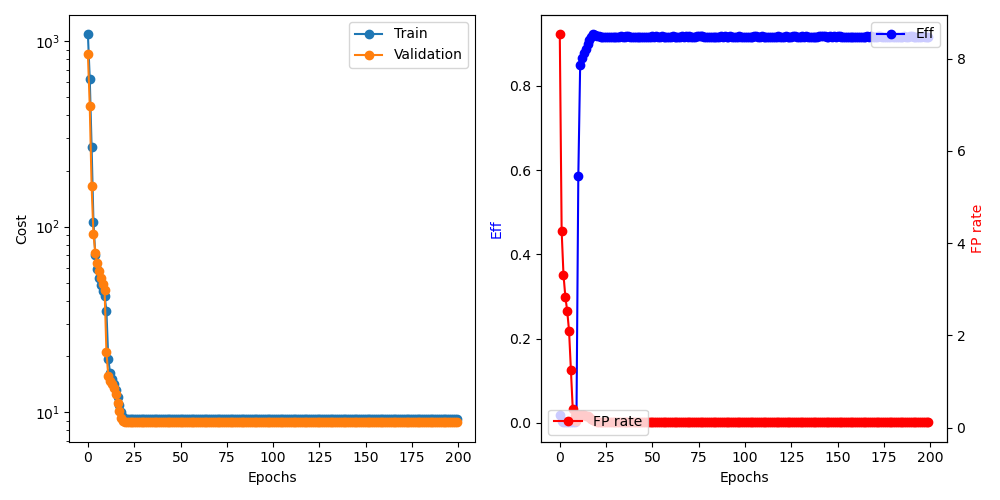

In [12]:
print('for model: ', model)   
run_name = 'SCNN to ACNN A'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate)) 
            
        # Redraw the figure
        fig.canvas.draw()  
        
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    fig.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()